# Dishwasher eco mode analysis

## Imports and setup


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.axes
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime
import scipy.integrate
from pint import UnitRegistry, Quantity
import os

# Initialize unit registry
ureg = UnitRegistry()

FILE_FORMAT = "svg"

DARK_MODE = False
if DARK_MODE:
    plt.style.use("dark_background")
    plt.rcParams["figure.facecolor"] = "#040711"  # Figure background
    plt.rcParams["axes.facecolor"] = "#040711"  # Axes background
else:
    plt.style.use("default")
    plt.rcParams["figure.facecolor"] = "white"
    plt.rcParams["axes.facecolor"] = "white"

# Get the default color cycle
default_colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

# Define paths
data_path = "data"
plots_dir = "plots/dark" if DARK_MODE else "plots/light"
plots_path = Path(data_path) / ".." / plots_dir
if DARK_MODE:
    plots_path = plots_path
os.makedirs(plots_path, exist_ok=True)

## Data classes


In [26]:
@dataclass
class DataPoint:
    state: float
    last_changed: datetime
    seconds_elapsed: float

## Load data, filter data, construct objects


In [27]:
mode_labels = {
    "eco": "eko",
    "eco_quick": "snabb eko",
}

modes = ["eco", "eco_quick"]
entity_id = "sensor.elmatare_diskmaskin_power"
START_STOP_THRESHOLD = 1.0  # Watts, below which we consider the machine to be off in the beginning and end of the data

data_points: dict[str, list[DataPoint]] = {mode: [] for mode in modes}

for mode in modes:
    raw_data = np.loadtxt(Path(data_path) / f"history-{mode}.csv", skiprows=1, delimiter=",", dtype=str)

    for row in [x for x in raw_data if x[0] == entity_id]:
        state = float(row[1])
        # If power is less than START_STOP_THRESHOLD and we dont have any datapoint yet,
        # skip it in order to get a time of 0 when starting
        if state < START_STOP_THRESHOLD and len(data_points[mode]) == 0:
            print(
                f"Skipping {row[0]} with state {state} and last_changed {row[2]} for {mode}, as no previous data points exist with non-neglible power"
            )
            continue

        last_changed = datetime.fromisoformat(row[2].replace("Z", "+00:00"))
        if len(data_points[mode]):
            seconds_elapsed = (last_changed - data_points[mode][0].last_changed).total_seconds()
        else:
            seconds_elapsed = 0
        data_points[mode].append(DataPoint(state, last_changed, seconds_elapsed))

    # Remove all trailing data points with state 0, excelt for the last one
    while (
        data_points[mode]
        and len(data_points[mode]) >= 2
        and data_points[mode][-1].state <= START_STOP_THRESHOLD
        and data_points[mode][-2].state <= START_STOP_THRESHOLD
    ):
        print(
            f"Removing trailing data point with state {data_points[mode][-1].state} for {mode} at {data_points[mode][-1].last_changed}"
        )
        data_points[mode].pop()

Skipping sensor.elmatare_diskmaskin_power with state 0.0 and last_changed 2025-05-20T16:00:00.000Z for eco, as no previous data points exist with non-neglible power
Skipping sensor.elmatare_diskmaskin_power with state 0.0 and last_changed 2025-05-18T13:00:00.000Z for eco_quick, as no previous data points exist with non-neglible power
Skipping sensor.elmatare_diskmaskin_power with state 0.1 and last_changed 2025-05-18T14:07:15.611Z for eco_quick, as no previous data points exist with non-neglible power
Skipping sensor.elmatare_diskmaskin_power with state 0.0 and last_changed 2025-05-18T14:07:20.667Z for eco_quick, as no previous data points exist with non-neglible power
Removing trailing data point with state 0.0 for eco_quick at 2025-05-18 16:09:57.891000+00:00
Removing trailing data point with state 0.1 for eco_quick at 2025-05-18 16:09:52.928000+00:00
Removing trailing data point with state 0.0 for eco_quick at 2025-05-18 16:02:30.574000+00:00
Removing trailing data point with state 

## Create visualizations


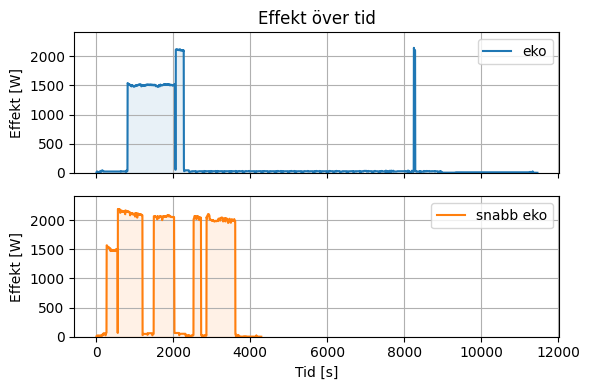

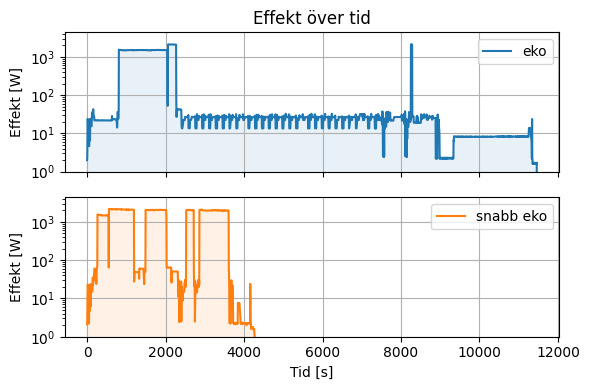

In [28]:
import matplotlib.pyplot as plt

# Prepare figure 0 (linear scale)
fig0, axes0 = plt.subplots(nrows=len(modes), sharex=True, figsize=(6, 2 * len(modes)))
# Prepare figure 1 (log scale)
fig1, axes1 = plt.subplots(nrows=len(modes), sharex=True, figsize=(6, 2 * len(modes)))

# If only one mode, axes won't be a list
if len(modes) == 1:
    axes0 = [axes0]
    axes1 = [axes1]

# Compute global y-limits for power plots
all_power_values = [x.state for mode in modes for x in data_points[mode]]
power_y_max = max(all_power_values)

for idx, mode in enumerate(modes):
    x = [x.seconds_elapsed for x in data_points[mode]]
    y = [x.state for x in data_points[mode]]
    color = default_colors[idx % len(default_colors)]  # cycle through default colors

    # Plot in linear scale figure
    ax0 = axes0[idx]
    ax0.plot(x, y, label=mode_labels[mode], color=color)
    ax0.fill_between(x=x, y1=y, color=color, alpha=0.1)
    ax0.set_ylabel("Effekt [W]")
    ax0.legend()
    ax0.grid()
    ax0.set_ylim(0, 1.1 * power_y_max)  # Linear scale

    # Plot in log scale figure
    ax1 = axes1[idx]
    ax1.semilogy(x, y, label=mode_labels[mode], color=color)
    ax1.fill_between(x=x, y1=y, color=color, alpha=0.1)
    ax1.set_ylabel("Effekt [W]")
    ax1.legend()
    ax1.grid()
    ax1.set_ylim(1, 2 * power_y_max)  # Log scale (avoid log(0))


# Set common x-label and titles
for fig, ax_list, fig_idx in zip([fig0, fig1], [axes0, axes1], [0, 1]):
    ax_list[-1].set_xlabel("Tid [s]")  # Only the bottom subplot gets the x-axis label
    ax_list[0].set_title(f"Effekt över tid")
    fig.tight_layout()
    fig.savefig(plots_path / f"power_vs_time_{entity_id}_{fig_idx}.{FILE_FORMAT}", facecolor=fig.get_facecolor())

Total energy consumed in eco mode: 0.71 kilowatt_hour
Elapsed time (hh:mm) in eco mode: 03:11 (or 11465 seconds)
Total energy consumed in eco_quick mode: 1.35 kilowatt_hour
Elapsed time (hh:mm) in eco_quick mode: 01:11 (or 4285 seconds)


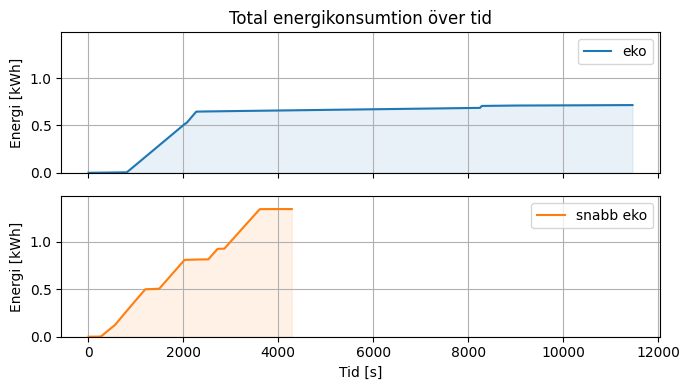

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.integrate

# Get the default color cycle
default_colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

# Dict for total energy
total_energy: dict[str, Quantity] = {}

# Create figure and axes
fig_energy, axes_energy = plt.subplots(nrows=len(modes), sharex=True, figsize=(7, 2 * len(modes)))

# If only one mode, axes won't be a list
if len(modes) == 1:
    axes_energy = [axes_energy]

for idx, mode in enumerate(modes):
    power_values = [x.state for x in data_points[mode]]
    time_values = [x.seconds_elapsed for x in data_points[mode]]

    # Integrate to get energy in joules
    energy_joule = scipy.integrate.cumulative_trapezoid(power_values, time_values, initial=0)

    # Convert to kWh
    energy_kwh = energy_joule / 3.6e6
    total_energy[mode] = energy_kwh[-1] * ureg.kWh

    # Print energy and time info
    elapsed_time = time_values[-1]
    elapsed_time_hhmm = f"{int(elapsed_time // 3600):02}:{int((elapsed_time % 3600) // 60):02}"
    print(f"Total energy consumed in {mode} mode: {total_energy[mode]:.2f}")
    print(f"Elapsed time (hh:mm) in {mode} mode: {elapsed_time_hhmm} (or {elapsed_time:.0f} seconds)")

    # Plot
    ax = axes_energy[idx]
    color = default_colors[idx % len(default_colors)]
    ax.plot(time_values, energy_kwh, label=mode_labels[mode], color=color)
    ax.fill_between(time_values, energy_kwh, color=color, alpha=0.1)
    ax.set_ylabel("Energi [kWh]")
    ax.legend()
    ax.grid()
    ax.set_ylim(bottom=0)

# Set y-axis limits to 1.1 times the maximum energy value of any mode
max_energy = max(total_energy[mode].magnitude for mode in modes)
for ax in axes_energy:
    ax.set_ylim(0, 1.1 * max_energy)  # Set y-axis to start at 0 and extend to 10% above max energy

# Add labels and title
axes_energy[0].set_title(f"Total energikonsumtion över tid")
axes_energy[-1].set_xlabel("Tid [s]")

fig_energy.tight_layout()
fig_energy.savefig(plots_path / f"energy_vs_time_{entity_id}.{FILE_FORMAT}", facecolor=fig_energy.get_facecolor())

## Calculate water usage


In [30]:
initial_temperature = 10 * ureg.delta_degC

final_temperatures: dict[str, Quantity] = {
    "eco": 50 * ureg.delta_degC,
    "eco_quick": 50 * ureg.delta_degC,
}

# Calculate the mass of water in the dishwasher based on the energy consumed
mass_water = {}

for mode in modes:
    # Calculate the mass of water in the dishwasher based on the energy consumed
    # Q = mcΔT
    # m = Q / (cΔT)
    # where Q is the energy consumed, c is the specific heat capacity of water (4.186 J/g°C),
    # and ΔT is the change in temperature (final - initial)
    delta_T = final_temperatures[mode] - initial_temperature

    c_water = 4.186 * ureg.J / (ureg.g * ureg.delta_degC)  # specific heat capacity of water

    mass_water[mode] = (total_energy[mode] / (c_water * delta_T)).to(ureg.kg)  # convert to kg

    print(f"Mass of water in {mode} mode: {mass_water[mode]:.2f} (temperature change: {delta_T})")

Mass of water in eco mode: 15.36 kilogram (temperature change: 40 delta_degree_Celsius)
Mass of water in eco_quick mode: 28.97 kilogram (temperature change: 40 delta_degree_Celsius)
